In [1]:
!pip install keras-tuner

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, ReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt  # Import KerasTuner
import os

In [3]:
# Load your dataset (replace 'your_data.csv' with actual file path)
df = pd.read_csv("/content/processed_crypto_data_corrected.csv")

In [4]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

In [5]:
cryptos = df['Crypto'].unique()

In [6]:
# Directory to save models
model_dir = "crypto_lstm_models"
os.makedirs(model_dir, exist_ok=True)

In [7]:
# Selecting relevant columns for LSTM
features = ['Open', 'High', 'Low', 'Volume', 'VWAP', 'Volatility', 'Price_Change', 'RSI', 'MACD',
            'MA_7', 'MA_14', 'EMA_7', 'EMA_14', 'Rolling_Std_7', 'Rolling_Std_14',
            'Day_of_Week', 'Month', 'Week_of_Year', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']

target = 'Close'
sequence_length = 5  # Reduced for better responsiveness

In [8]:
# Define model builder function for KerasTuner
def build_model(hp):
    model = Sequential([
        Input(shape=(sequence_length, len(features))),
        LSTM(hp.Int('units_1', min_value=64, max_value=256, step=64), return_sequences=True),
        Dropout(hp.Choice('dropout_1', [0.02, 0.04, 0.06])),
        LSTM(hp.Int('units_2', min_value=64, max_value=256, step=64), return_sequences=True),
        Dropout(hp.Choice('dropout_2', [0.02, 0.04, 0.06])),
        LSTM(hp.Int('units_3', min_value=64, max_value=256, step=64), return_sequences=False),
        Dropout(hp.Choice('dropout_3', [0.02, 0.04, 0.06])),
        Dense(50),
        ReLU(),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.005, 0.007, 0.01])),
        loss=Huber()
    )
    return model

In [9]:
# Initialize KerasTuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train for each set of hyperparameters
    directory='lstm_tuning',
    project_name='crypto_forecasting'
)

Reloading Tuner from lstm_tuning/crypto_forecasting/tuner0.json


In [10]:
crypto_predictions = {}

for crypto in cryptos:
    print(f"Training LSTM model for {crypto} with Hyperparameter Tuning...")

    crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto'])
    crypto_df = crypto_df.dropna()

    scaler = MinMaxScaler()
    crypto_scaled = scaler.fit_transform(crypto_df[features + [target]])
    crypto_scaled = pd.DataFrame(crypto_scaled, columns=features + [target], index=crypto_df.index)

    train_size = int(len(crypto_scaled) * 0.8)
    train, test = crypto_scaled.iloc[:train_size], crypto_scaled.iloc[train_size:]

    if len(test) < sequence_length:
        print(f"Skipping {crypto}, not enough test data.")
        continue

    x_train, y_train, x_test, y_test = [], [], [], []

    for i in range(sequence_length, len(train)):
        x_train.append(train.iloc[i-sequence_length:i][features].values)
        y_train.append(train.iloc[i][target])

    for i in range(sequence_length, len(test)):
        x_test.append(test.iloc[i-sequence_length:i][features].values)
        y_test.append(test.iloc[i][target])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=1)

    best_hps_list = tuner.get_best_hyperparameters(num_trials=1)
    if not best_hps_list:
        print(f"Skipping {crypto}, no optimal hyperparameters found.")
        continue

    best_hps = best_hps_list[0]
    model = build_model(best_hps)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # ✅ Save trained model for each cryptocurrency
    model.save(os.path.join(model_dir, f"LSTM_{crypto}.h5"))
    print(f"Model saved: {model_dir}/LSTM_{crypto}.h5")

    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

    y_pred = model.predict(x_test)
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[sequence_length:][features].values, y_pred), axis=1))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((test.iloc[sequence_length:][features].values, y_test.reshape(-1,1)), axis=1))[:, -1]

    crypto_predictions[crypto] = {
        "actual": y_test_rescaled,
        "predicted": y_pred_rescaled,
        "dates": test.index[sequence_length:]
    }

Training LSTM model for Bitcoin with Hyperparameter Tuning...


Model saved: crypto_lstm_models/LSTM_Bitcoin.h5
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 279ms/step - loss: 0.0487 - val_loss: 0.0030
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0041 - val_loss: 0.0070
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0010 - val_loss: 0.0204
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.8352e-04 - val_loss: 0.0107
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 4.9758e-04 - val_loss: 0.0105
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.3369e-04 - val_loss: 0.0129
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.0993e-04 - val_loss: 0.0111
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 3.7364e-04 - val_loss: 0.0111
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 3.8380e-04 - val_loss: 0.0179
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.7960e-04 - val_loss: 0.0080
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 3.3889e-04 

Model saved: crypto_lstm_models/LSTM_Cardano.h5
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0018 - val_loss: 0.0079
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 8.6819e-04 - val_loss: 0.0081
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0011 - val_loss: 0.0231
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.8757e-04 - val_loss: 0.0106
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.8604e-04 - val_loss: 0.0097
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.9109e-04 - val_loss: 0.0091
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 5.1661e-04 - val_loss: 0.0089
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.7442e-04 - val_loss: 0.0082
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.4266e-04 - val_loss: 0.0066
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.6995e-04 - 

Model saved: crypto_lstm_models/LSTM_Chainlink.h5
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.0341 - val_loss: 0.0125
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0031 - val_loss: 0.0069
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0014 - val_loss: 0.0070
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 9.9943e-04 - val_loss: 0.0052
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0010 - val_loss: 0.0087
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 9.5389e-04 - val_loss: 0.0062
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 9.8386e-04 - val_loss: 0.0067
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.4631e-04 - val_loss: 0.0068
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.8262e-04 - val_loss: 0.0080
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 9.3865e-04 - val_loss: 0.0042
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 7.5842e-04 - v

1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 532ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Training LSTM model for Dogecoin with Hyperparameter Tuning...


Model saved: crypto_lstm_models/LSTM_Dogecoin.h5
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0065 - val_loss: 0.0311
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.3364e-04 - val_loss: 0.0362
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.8719e-04 - val_loss: 0.0374
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.2876e-04 - val_loss: 0.0455
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 3.8002e-04 - val_loss: 0.0374
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 2.4379e-04 - val_loss: 0.0330
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 2.5041e-04 - val_loss: 0.0531
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 4.2925e-04 - val_loss: 0.0662
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 4.2186e-04 - val_loss: 0.0534
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 3.0892e-04 - val_loss: 0.0505
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 

Model saved: crypto_lstm_models/LSTM_Ethereum.h5
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 0.0351 - val_loss: 0.0052
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0022 - val_loss: 0.0062
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0015 - val_loss: 0.0082
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 12/50
18

Model saved: crypto_lstm_models/LSTM_Litecoin.h5
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.0555 - val_loss: 0.0551
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0054 - val_loss: 0.0163
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0031 - val_loss: 0.0186
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0020 - val_loss: 0.0124
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0023 - val_loss: 0.0118
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0019 - val_loss: 0.0087
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0025 - val_loss: 0.0145
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0018 - val_loss: 0.0130
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0019 - val_loss: 0.0153
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0014 - val_loss: 0.0087
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0017 - val_loss: 0.0123
Epoch 12/50
1

Model saved: crypto_lstm_models/LSTM_Polkadot.h5
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0273 - val_loss: 0.0086
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0031 - val_loss: 0.0062
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 9.3311e-04 - val_loss: 0.0031
Epoch 12/5

Model saved: crypto_lstm_models/LSTM_Polygon.h5
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0930 - val_loss: 0.0048
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0097 - val_loss: 0.0070
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 12/50
18/

Model saved: crypto_lstm_models/LSTM_Ripple.h5
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.0016 - val_loss: 0.1178
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 3.5611e-04 - val_loss: 0.0824
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.7105e-04 - val_loss: 0.0378
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.4065e-04 - val_loss: 0.0345
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 8.0125e-05 - val_loss: 0.0461
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 6.9871e-05 - val_loss: 0.0367
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 6.6785e-05 - val_loss: 0.0522
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.0508e-05 - val_loss: 0.0380
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.4942e-05 - val_loss: 0.0399
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 7.6719e-05 - val_loss: 0.0521
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 7.0671

Model saved: crypto_lstm_models/LSTM_Solana.h5
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 0.0405 - val_loss: 0.0134
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0031 - val_loss: 0.0122
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0011 - val_loss: 0.0221
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 9.6680e-04 - val_loss: 0.0107
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 9.3018e-04 - val_loss: 0.0042
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 7.2231e-04 - val_loss: 0.0093
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 7.6643e-04 - val_loss: 0.0096
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 7.8230e-04 - val_loss: 0.0050
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 7.6680e-04 - val_loss: 0.0041
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 5.6869e-04 - val_l

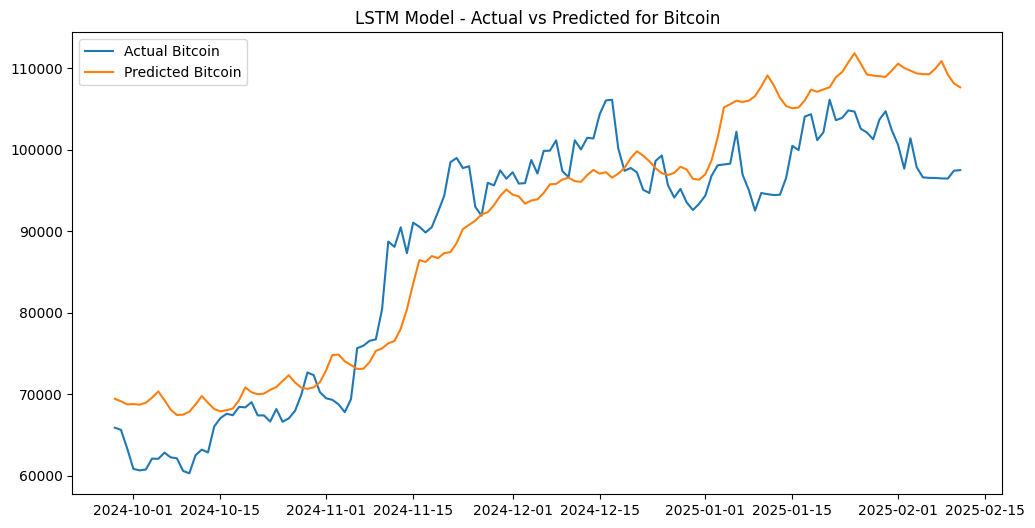

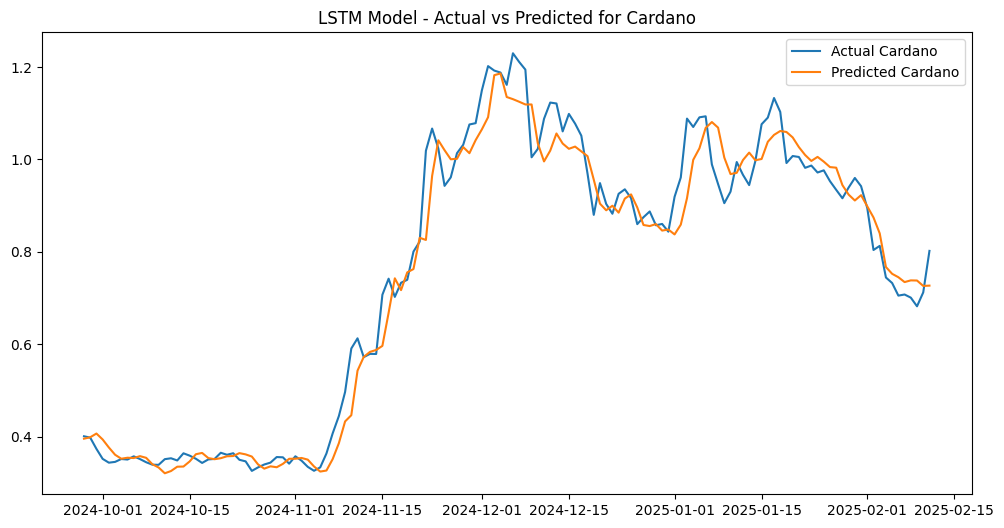

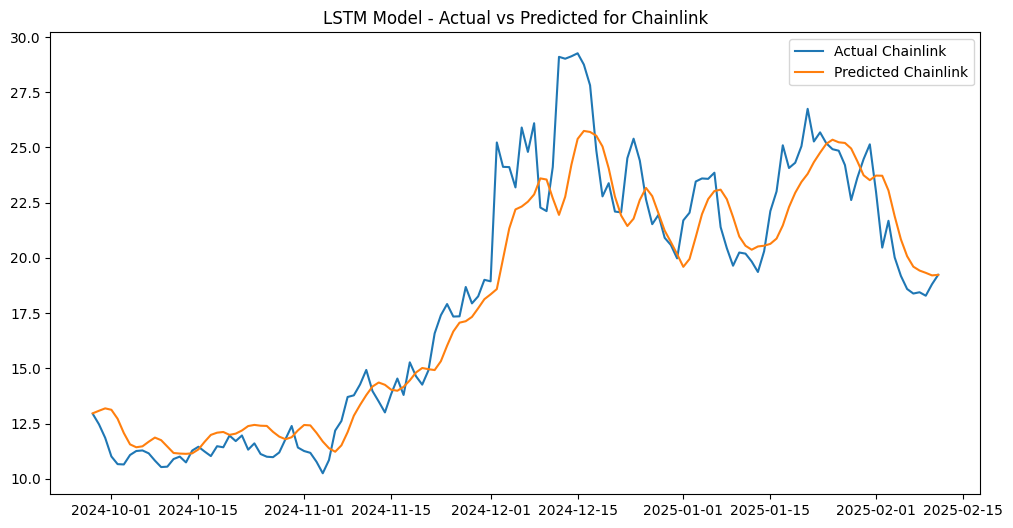

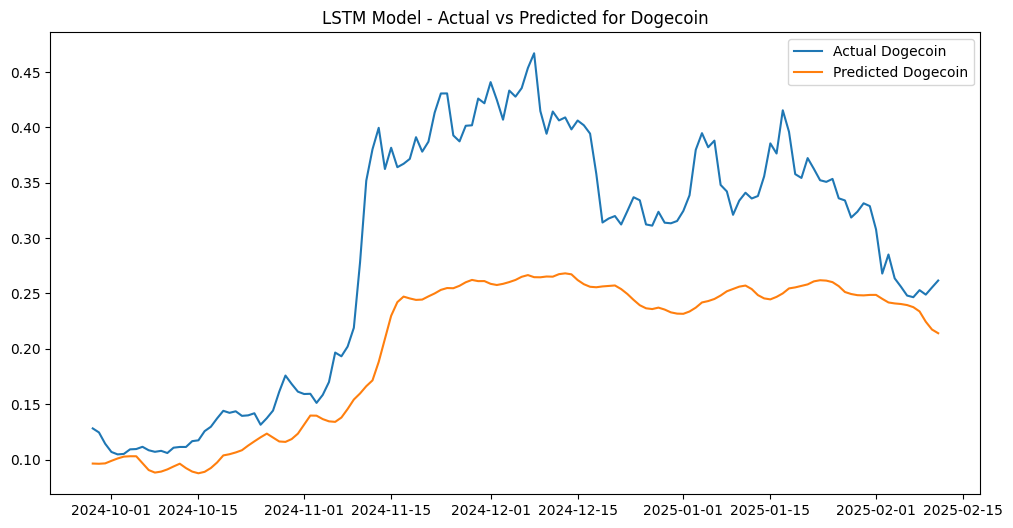

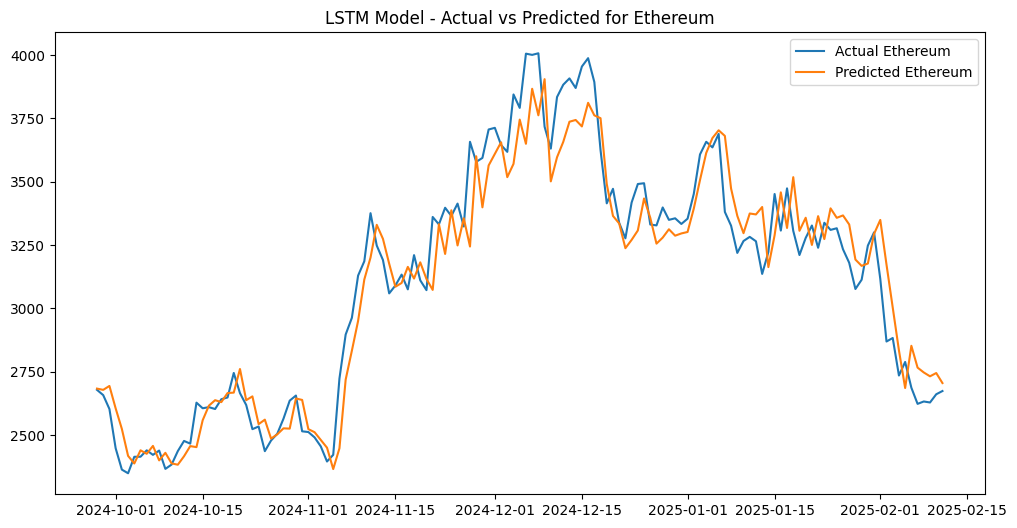

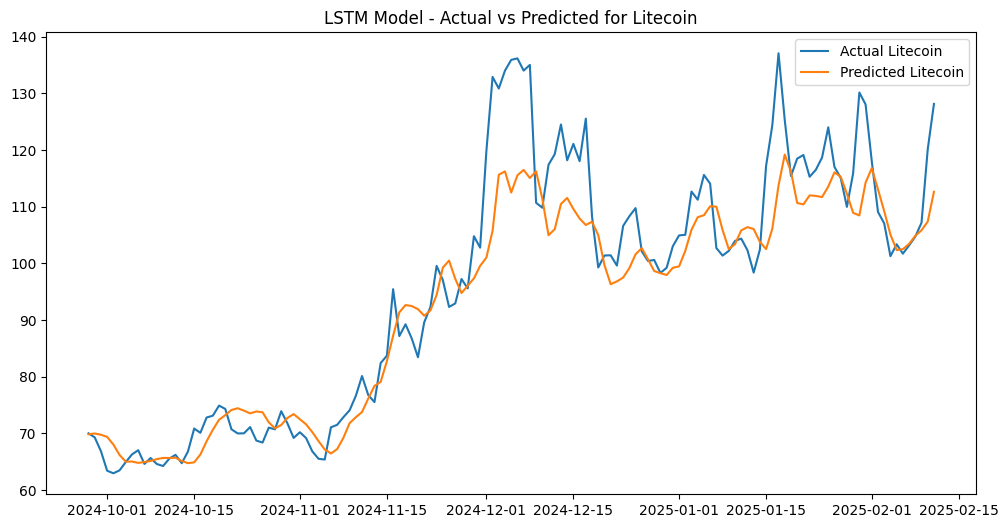

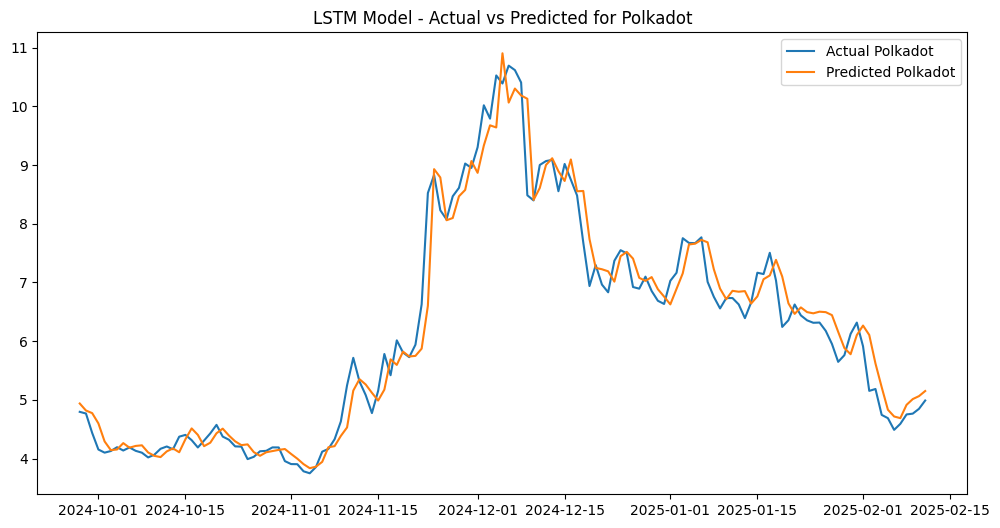

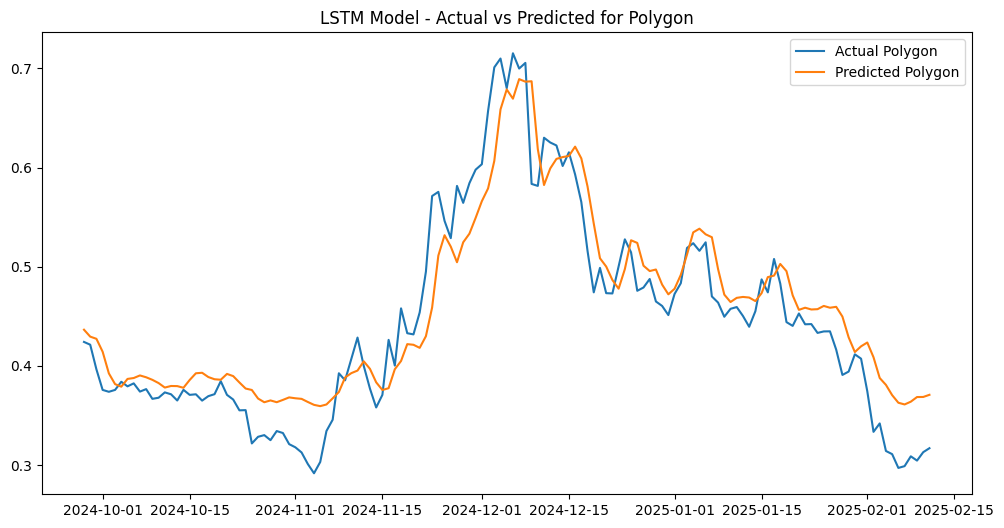

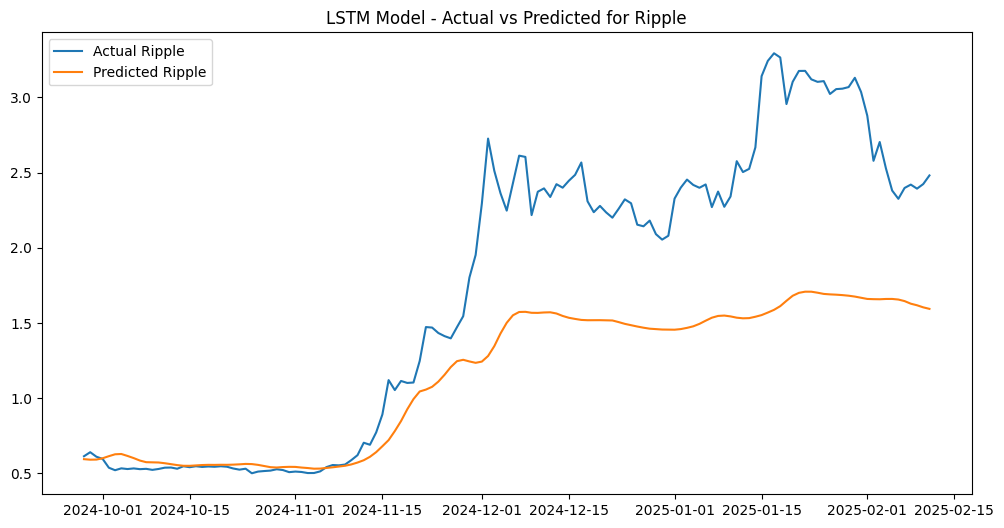

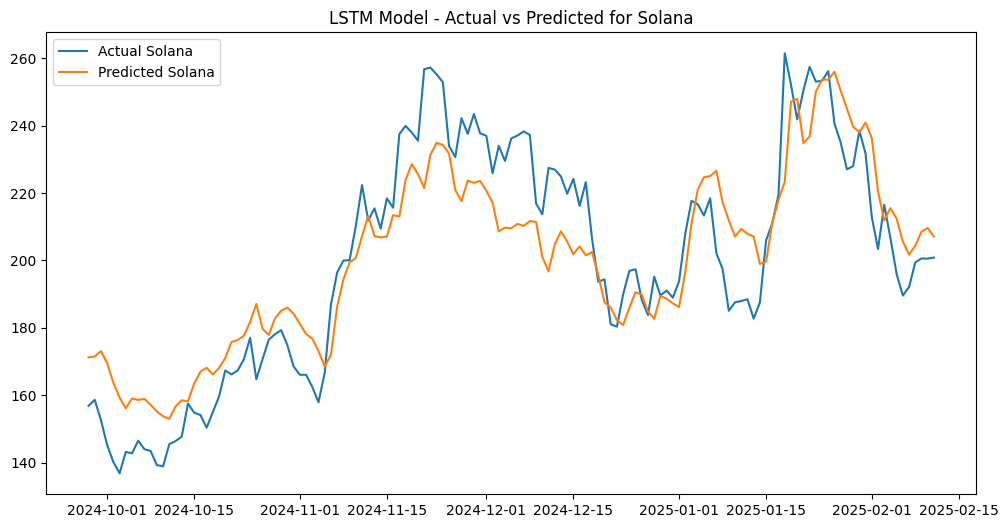

In [11]:
for crypto in crypto_predictions.keys():
    data = crypto_predictions[crypto]

    plt.figure(figsize=(12, 6))
    plt.plot(data["dates"], data["actual"], label=f'Actual {crypto}')
    plt.plot(data["dates"], data["predicted"], label=f'Predicted {crypto}')
    plt.legend()
    plt.title(f'LSTM Model - Actual vs Predicted for {crypto}')
    plt.show()

In [12]:
#from tensorflow.keras.models import load_model

# Load the trained model for Bitcoin
#bitcoin_model = load_model("crypto_lstm_models/LSTM_Bitcoin.h5")

In [13]:
#from keras_tuner import HyperParameters

# Load best hyperparameters
#import json
#with open("lstm_tuning/crypto_forecasting/tuner0.json", "r") as f:
#    best_hps_dict = json.load(f)

#best_hps = HyperParameters()
#best_hps.values = best_hps_dict  # Now you can use these hyperparameters

# Build the model using the best hyperparameters
#model = build_model(best_hps)